In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA 

In [2]:
import tensorflow as tf
import tensorflow.keras

In [3]:
np.random.seed(1234)

## Problem

We have a dataset with all projects from Kickstarter for the last year. We want to understand what makes a project successful based on the data we have. 
- What are the reasons for a Kickstarter project to be successful?
- What are the characteris of a successful Kickstarter project?

## Read the data

In [4]:
data = pd.read_csv('data/ks-projects-201801.csv')

## Train-Test Split

Splitting the data into train and test data. For Validation it will be used cross-validation. **Stratiffied Shuffle Split.**

In [5]:
data_train, data_test = train_test_split(data, test_size=0.1, stratify=data["category"])

Checking whether the stratification by category is giving a good stratification by **main_category** and **state** as well. It seems everything is okay - all main categories are stratified around 90%

In [6]:
data_train["main_category"].value_counts() / data["main_category"].value_counts() * 100

Film & Video    90.003932
Music           90.003467
Publishing      89.998495
Games           89.997445
Technology      89.993552
Design          90.000000
Art             90.001066
Food            90.033331
Fashion         90.002630
Theater         89.947769
Comics          89.943618
Photography     90.008350
Crafts          90.021569
Journalism      90.010515
Dance           89.941614
Name: main_category, dtype: float64

In [7]:
data_train["state"].value_counts() / data["state"].value_counts() * 100

failed        90.051032
successful    89.954164
canceled      89.842440
undefined     90.174060
live          90.853876
suspended     89.490791
Name: state, dtype: float64

## Discover the data

In [8]:
data_train

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
268788,437827266,Vegan Antics - A 100% Vegan Bakery,Vegan,Food,GBP,2016-10-04,5000.0,2016-09-04 18:07:14,207.0,failed,13,GB,19.94,255.22,6164.70
172263,1876085348,The BRIM BAND Company,Accessories,Fashion,USD,2016-02-22,25000.0,2016-01-01 18:04:04,135.0,failed,2,US,135.00,135.00,25000.00
204609,2042318332,Pact Magic Unbound: Grimoire of Lost Souls for...,Tabletop Games,Games,USD,2015-03-28,2500.0,2015-02-26 12:41:38,9826.0,successful,242,US,9826.00,9826.00,2500.00
99083,1502985139,Cuvee 103 Bistro,Restaurants,Food,USD,2015-12-24,50000.0,2015-11-30 20:20:48,0.0,failed,0,US,0.00,0.00,50000.00
378274,998212114,Bizarre Noir * Pop Songs for Ugly People * alb...,Rock,Music,USD,2016-11-28,1200.0,2016-11-05 17:45:43,1420.0,successful,30,US,620.00,1420.00,1200.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262660,40599481,Kids Are Awful (Canceled),Children's Books,Publishing,USD,2015-04-29,6500.0,2015-03-29 23:45:39,3067.0,canceled,46,US,3067.00,3067.00,6500.00
265446,420357420,"""Not Mother"": A Film About Kids, School, and A...",Shorts,Film & Video,USD,2011-01-10,2000.0,2010-12-09 03:27:26,2010.0,successful,26,US,2010.00,2010.00,2000.00
108102,1549582535,Ballin' From Grace,Music,Music,USD,2015-06-09,75000.0,2015-05-23 05:09:07,0.0,failed,0,US,0.00,0.00,75000.00
33761,1171444783,"""Creative Spirit"" - a film: Keith Medley's 27-...",Documentary,Film & Video,USD,2011-06-06,40000.0,2011-03-07 18:43:21,4696.0,failed,36,US,4696.00,4696.00,40000.00


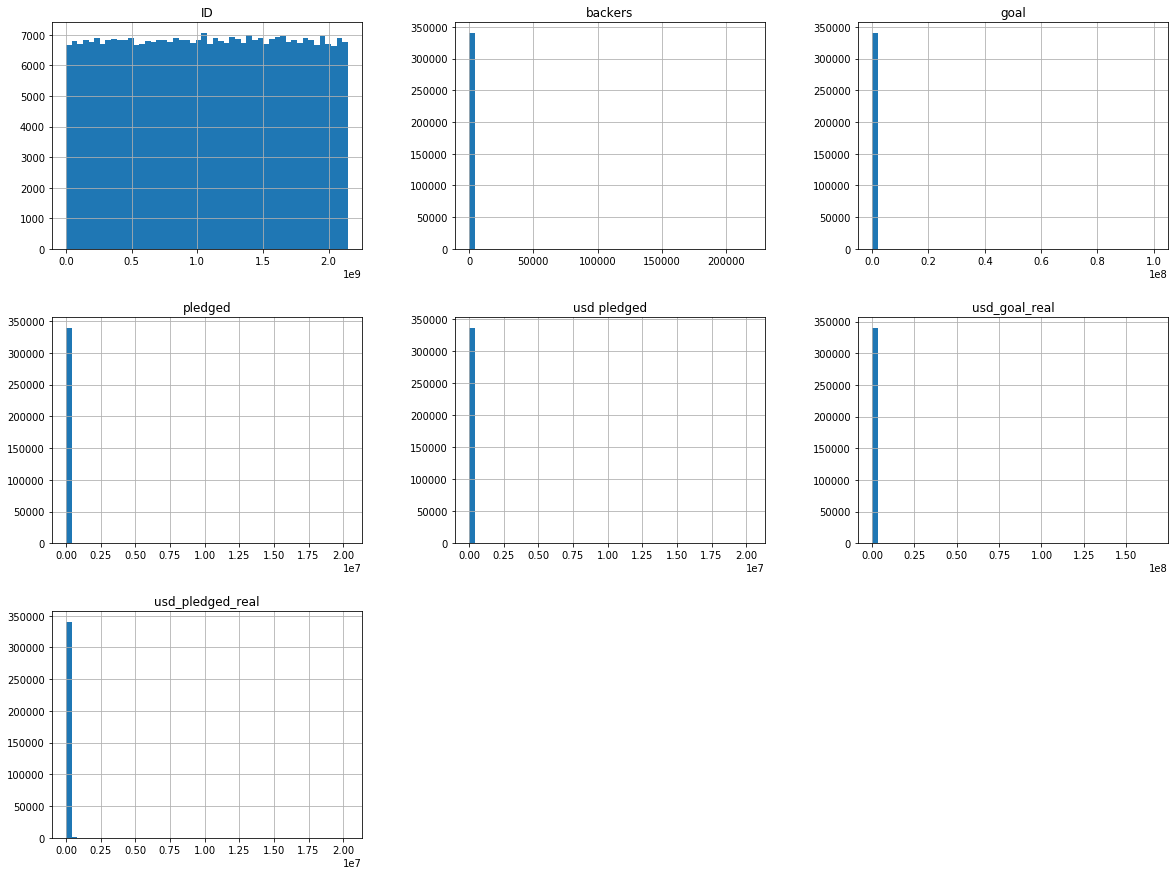

In [9]:
data_train.hist(bins=50, figsize=(20,15))
plt.show()

In [10]:
backers_log = np.log2(data_train["backers"])
backers_log[backers_log < 0] = 0 # backers -inf are just 0 backers

C:\Users\VGeorgiev\Anaconda3\lib\site-packages\pandas\core\series.py:853: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


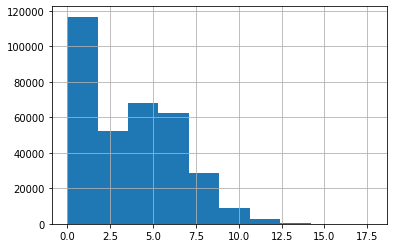

In [11]:
backers_log.hist()

### Display number of values of categorical features

Categorical features has to be one-hot encoded. Unfortunately, too many features will not help us with the model. It has to be decided which features to use.

In [12]:
categorical_features = data[['category', 'main_category', 'currency', 'country']]
for category in categorical_features:
    print(f'"{category}" has {len(categorical_features[category].value_counts())} values.')

"category" has 159 values.
"main_category" has 15 values.
"currency" has 14 values.
"country" has 23 values.


### Displaying the most successful and failed main_categories

In [13]:
data[data["state"] == "undefined"]

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
169,1000694855,STREETFIGHTERZ WHEELIE MURICA,Film & Video,Film & Video,USD,2014-09-20,6500.0,2014-08-06 21:28:36,555.00,undefined,0,"N,0""",NaN,555.00,6500.00
328,100149523,Duncan Woods - Chameleon EP,Music,Music,AUD,2015-08-25,4500.0,2015-08-04 12:05:17,4767.00,undefined,0,"N,0""",NaN,3402.08,3211.53
632,1003023003,The Making of Ashley Kelley's Debut Album,Music,Music,USD,2015-04-09,3500.0,2015-03-10 20:06:13,3576.00,undefined,0,"N,0""",NaN,3576.00,3500.00
647,1003130892,Butter Side Down Debut Album,Music,Music,USD,2015-11-26,6000.0,2015-11-02 22:09:19,7007.80,undefined,0,"N,0""",NaN,7007.80,6000.00
749,1003629045,Chase Goehring debut EP,Music,Music,USD,2016-03-21,3000.0,2016-02-23 03:09:49,3660.38,undefined,0,"N,0""",NaN,3660.38,3000.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378233,997971307,"EQUUS International Film Festival®, all-equine...",Film & Video,Film & Video,USD,2015-02-03,7500.0,2014-12-05 04:19:14,10.00,undefined,0,"N,0""",NaN,10.00,7500.00
378303,998319149,Emily 2050 - Short Film,Film & Video,Film & Video,CAD,2014-05-23,3000.0,2014-04-08 00:30:09,3102.00,undefined,0,"N,0""",NaN,2845.61,2752.04
378434,9988744,Matthew Stephens Music,Music,Music,USD,2016-02-05,5000.0,2016-01-06 21:59:23,235.00,undefined,0,"N,0""",NaN,235.00,5000.00
378585,999610349,Lady Vendredi: Afrofuturist concept 12 inch EP,Music,Music,GBP,2015-10-19,2000.0,2015-09-21 22:33:18,2125.00,undefined,0,"N,0""",NaN,3273.36,3080.81


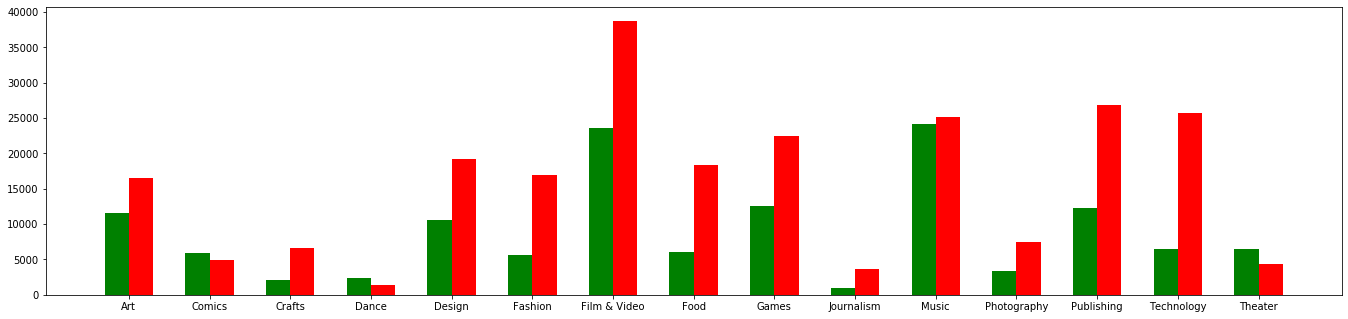

failed        197719
successful    133956
canceled       38779
suspended       1846
Name: state, dtype: int64

In [14]:
main_cats = data[data["state"] != "live"]
main_cats = main_cats[main_cats["state"] != "undefined"]
main_cats_sucess = main_cats[main_cats["state"] == "successful"]["main_category"].value_counts().sort_index()
main_cats_failed = main_cats[main_cats["state"] != "successful"]["main_category"].value_counts().sort_index()

fig = plt.figure()

ind = np.arange(len(main_cats_sucess)) 
width = 0.3

ax = fig.add_axes([0,0,3,1])
ax.bar(ind, list(main_cats_sucess.values), width = width, color = "g")
ax.bar(ind + width, list(main_cats_failed.values), width = width, color = "r")

plt.xticks(ind + width / 2, main_cats_sucess.index)

plt.show()

main_cats["state"].value_counts()

### Displaying the most successful and failed main_categories (percentage)
Displaying the percentage of the successful/unsuccessful projects are crutial, because the distribution between categories is not balanced. Meaning that a plot by the number of projects can trick our minds which category is more successful than other.

Notes:
- "Live" and "undefined" projects are excluded
- Unsuccessful project means: failed, canceled, undefined, suspended

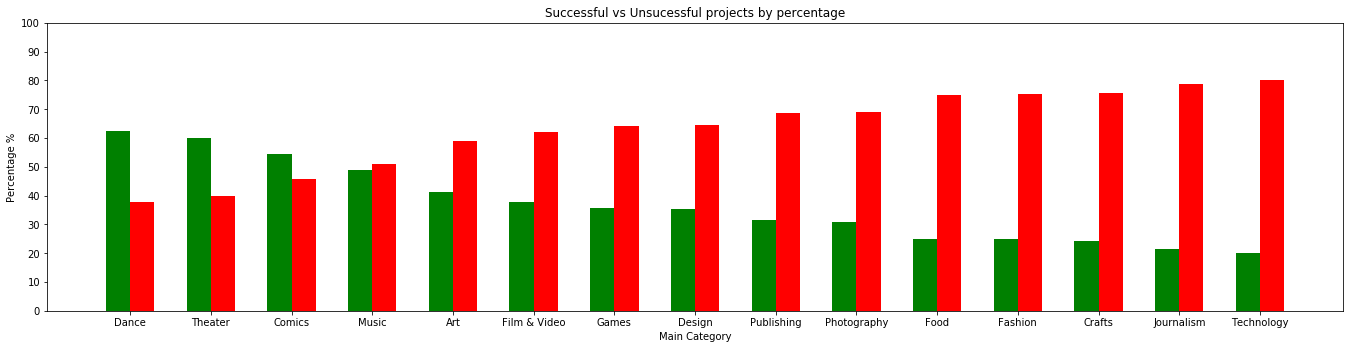

In [15]:
main_cats_all = main_cats['main_category'].value_counts().sort_index()
main_cats_success_percentage = main_cats_sucess / main_cats_all * 100
main_cats_failed_percentage = main_cats_failed / main_cats_all * 100
main_cats_success_percentage = main_cats_success_percentage.sort_values(ascending=False)
main_cats_failed_percentage = main_cats_failed_percentage.reindex(main_cats_success_percentage.index)

fig = plt.figure()

ind = np.arange(len(main_cats_success_percentage)) 
width = 0.3

ax = fig.add_axes([0,0,3,1])
ax.bar(ind, list(main_cats_success_percentage.values), width = width, color = "g")
ax.bar(ind + width, list(main_cats_failed_percentage.values), width = width, color = "r")

plt.title("Successful vs Unsucessful projects by percentage")
plt.ylabel("Percentage %")
plt.xlabel("Main Category")
plt.yticks(np.arange(0, 101, 10))
plt.xticks(ind + width / 2, main_cats_success_percentage.index)

plt.show()

### Displaying the most successful and failed categories

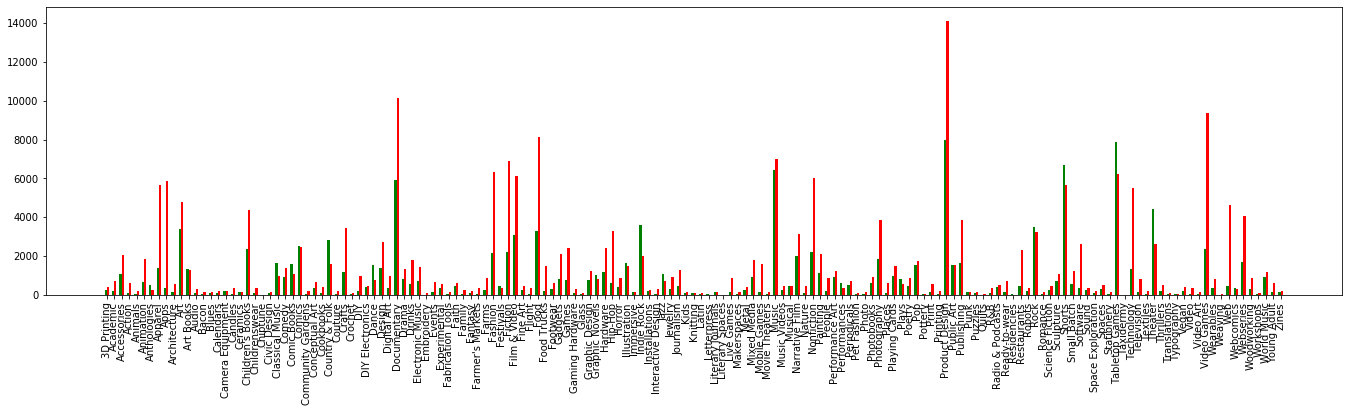

In [16]:
cats_sucess = main_cats[main_cats["state"] == "successful"]["category"].value_counts().sort_index()
cats_failed = main_cats[main_cats["state"] != "successful"]["category"].value_counts().sort_index()

fig = plt.figure()

ind = np.arange(len(cats_sucess)) 
width = 0.3

ax = fig.add_axes([0,0,3,1])
ax.bar(ind, list(cats_sucess.values), width = width, color = "g")
ax.bar(ind + width, list(cats_failed.values), width = width, color = "r")

plt.xticks(ind + width / 2, cats_sucess.index, rotation='vertical')

plt.show()

### Displaying the most successful and failed categories (percentage)

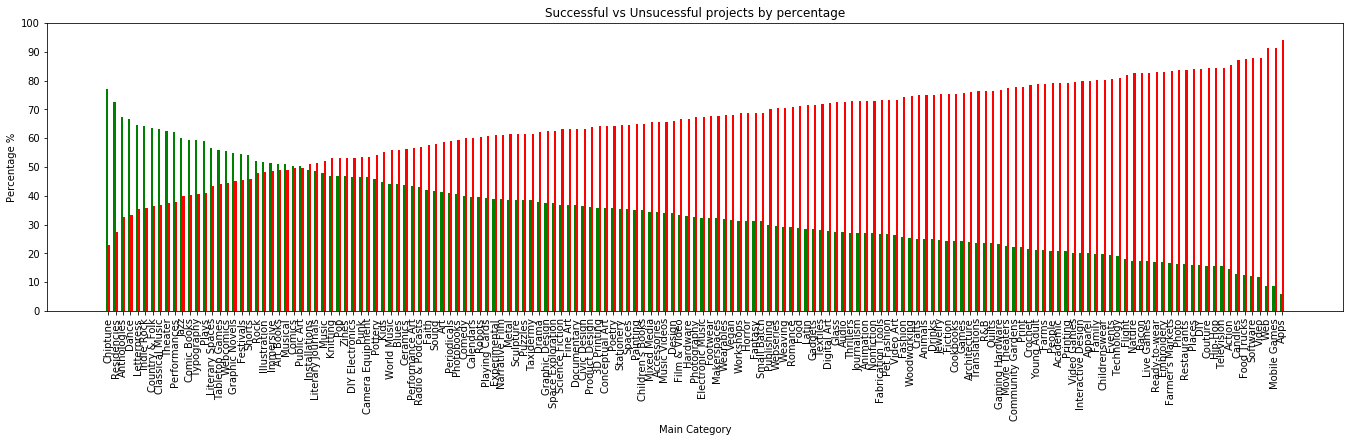

In [17]:
cats_all = main_cats['category'].value_counts().sort_index()
cats_success_percentage = cats_sucess / cats_all * 100
cats_failed_percentage = cats_failed / cats_all * 100
cats_success_percentage = cats_success_percentage.sort_values(ascending=False)
cats_failed_percentage = cats_failed_percentage.reindex(cats_success_percentage.index)

fig = plt.figure()

ind = np.arange(len(cats_success_percentage)) 
width = 0.3

ax = fig.add_axes([0,0,3,1])
ax.bar(ind, list(cats_success_percentage.values), width = width, color = "g")
ax.bar(ind + width, list(cats_failed_percentage.values), width = width, color = "r")

plt.title("Successful vs Unsucessful projects by percentage")
plt.ylabel("Percentage %")
plt.xlabel("Main Category")
plt.yticks(np.arange(0, 101, 10))
plt.xticks(ind + width / 2, cats_success_percentage.index, rotation='vertical')

plt.show()

### Finding the most successful projects based on correlations

There is high correlation for **backers** and **pledged** money, which is normal. The correlations between categories are not strong. It can be seen that projects from US and with USD currency are most successful. 

In [18]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [19]:
data["country"].value_counts()

US      292627
GB       33672
CA       14756
AU        7839
DE        4171
N,0"      3797
FR        2939
IT        2878
NL        2868
ES        2276
SE        1757
MX        1752
NZ        1447
DK        1113
IE         811
CH         761
NO         708
HK         618
BE         617
AT         597
SG         555
LU          62
JP          40
Name: country, dtype: int64

In [20]:
dummies_corr = pd.get_dummies(data, columns = ["main_category", "currency", "country", "state"]).corr()
dummies_corr["state_successful"].sort_values(ascending=False)

state_successful              1.000000
backers                       0.129109
pledged                       0.111534
usd_pledged_real              0.110704
usd pledged                   0.097791
main_category_Music           0.093623
main_category_Theater         0.088260
country_US                    0.076169
main_category_Comics          0.066792
currency_USD                  0.065202
main_category_Dance           0.055926
main_category_Art             0.032645
main_category_Film & Video    0.016683
country_GB                    0.003010
main_category_Games           0.001038
currency_GBP                  0.000123
country_HK                   -0.000359
currency_HKD                 -0.000359
ID                           -0.001200
country_LU                   -0.001266
main_category_Design         -0.001790
country_SG                   -0.002648
currency_SGD                 -0.002648
country_DK                   -0.003442
currency_DKK                 -0.003789
country_JP               

## Feature Engineering

### Transform dates

#### Dates insights and decisions
Based on the correlations and observations, it seems that year and day information about launches and deadlines does not give us a lot of information. Only months will be used in order to gain knowledge which are the best months for starting and ending a project.

In [21]:
data_processed = data.copy()
data_processed['launched_month'] = pd.DatetimeIndex(data['launched']).month
data_processed['deadline_month'] = pd.DatetimeIndex(data['deadline']).month

### Creating new feature - duration of a project

The lanuch date and deadline don't give us a lot of information, except the start and end month. Some of the months are better to start or end a project. So maybe the duration of the project is something we can gain insight from.

In [22]:
from datetime import date
launched = pd.DatetimeIndex(data_processed['launched'])
deadline = pd.DatetimeIndex(data_processed['deadline'])

data_processed["duration"] = (deadline - launched).days

#### Annomalies

There are project with extremely high duration and it seems they are with lauched date 1970. They will be deleted.

In [23]:
data_processed[data_processed["duration"] > 10000]

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,launched_month,deadline_month,duration
2842,1014746686,Salt of the Earth: A Dead Sea Movie (Canceled),Film & Video,Film & Video,USD,2010-09-15,5000.0,1970-01-01 01:00:00,0.0,canceled,0,US,0.0,0.0,5000.00,1,9,14866
48147,1245461087,1st Super-Size Painting - Social Network Owned...,Art,Art,USD,2010-08-14,15000.0,1970-01-01 01:00:00,0.0,canceled,0,US,0.0,0.0,15000.00,1,8,14834
75397,1384087152,"""ICHOR"" (Canceled)",Film & Video,Film & Video,USD,2010-05-21,700.0,1970-01-01 01:00:00,0.0,canceled,0,US,0.0,0.0,700.00,1,5,14749
94579,1480763647,"Support Solo Theater! Help ""Ungrateful Daughte...",Theater,Theater,USD,2010-06-01,4000.0,1970-01-01 01:00:00,0.0,canceled,0,US,0.0,0.0,4000.00,1,6,14760
247913,330942060,"Help RIZ Make A Charity Album: 8 Songs, 8 Caus...",Music,Music,USD,2010-05-04,10000.0,1970-01-01 01:00:00,0.0,canceled,0,US,0.0,0.0,10000.00,1,5,14732
273779,462917959,Identity Communications Infographic (Canceled),Design,Design,USD,2010-04-10,500.0,1970-01-01 01:00:00,0.0,canceled,0,US,0.0,0.0,500.00,1,4,14708
319002,69489148,Student Auditions Music 2015,Publishing,Publishing,CHF,2015-10-31,1900.0,1970-01-01 01:00:00,0.0,suspended,0,CH,0.0,0.0,1905.97,1,10,16738


## Data Preparation

### Columns cleaning

In [24]:
data_processed = data_processed.drop(['ID', 'name', 'deadline', 'launched', 'goal', 'pledged', 'usd pledged'], axis=1)

In [25]:
data_processed = data_processed.drop(['usd_pledged_real', 'backers'], axis=1)

### Data Cleaning

In [26]:
data_processed = data_processed[data_processed["duration"] < 10000]

In [27]:
data_processed = data_processed[data_processed['state'] != 'live']
data_processed = data_processed[data_processed['state'] != 'undefined']

### One-hot encoding

- Encode **launched_month** and **deadline_month**

In [28]:
data_processed = pd.get_dummies(data_processed, columns = ["main_category"]) # , "category", "country", "currency"

In [29]:
data_processed = data_processed.drop(['country', 'currency', 'category'], axis=1)

### Feature Scaling

- Scale **usd_pledged_real** and **usd_goal_real**

In [54]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()
data_processed['usd_goal_real'] = scaler.fit_transform(data_processed[['usd_goal_real']])

In [55]:
data_processed['usd_goal_real'].describe()

count    372293.000000
mean          0.000275
std           0.006921
min           0.000000
25%           0.000012
50%           0.000033
75%           0.000096
max           1.000000
Name: usd_goal_real, dtype: float64

### Label Extraction

In [32]:
data_labels = data_processed['state']
data_processed = data_processed.drop(['state'], axis=1)

## Train Linear Classification

In [56]:
data_processed

,usd_goal_real,launched_month,deadline_month,duration,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,main_category_Food,main_category_Games,main_category_Journalism,main_category_Music,main_category_Photography,main_category_Publishing,main_category_Technology,main_category_Theater
0,0.000009,8,10,58,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0.000180,9,11,59,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,0.000270,1,2,44,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0.000030,3,4,29,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0.000117,7,8,55,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378656,0.000301,9,10,29,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
378657,0.000009,6,7,26,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
378658,0.000090,7,8,45,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
378659,0.000090,1,2,30,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [33]:
data_labels = (data_labels == 'successful')

In [34]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier()
sgd_clf.fit(data_processed, data_labels)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [35]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, data_processed, data_labels, cv=3, scoring="f1_macro")

array([0.57511321, 0.55993078, 0.47341789])

In [36]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

predictions = cross_val_predict(sgd_clf, data_processed, data_labels, cv=3)
confusion_matrix(data_labels, predictions) # [[TN, FP], [FN, TP]]

array([[221199,  17138],
       [110380,  23576]], dtype=int64)

In [37]:
from sklearn.metrics import precision_score, recall_score
precision_score(data_labels, predictions), recall_score(data_labels, predictions)

(0.5790637127278087, 0.17599808892472155)

## Train Decision Tree Classifier

In [38]:
from sklearn.tree import DecisionTreeClassifier
tree_clf = DecisionTreeClassifier()

In [39]:
cross_val_score(tree_clf, data_processed, data_labels, cv=3, scoring="f1_macro")

array([0.57319769, 0.57408423, 0.57072924])

In [40]:
tree_predictions = cross_val_predict(sgd_clf, data_processed, data_labels, cv=3)
confusion_matrix(data_labels, tree_predictions) # [[TN, FP], [FN, TP]]

array([[219827,  18510],
       [109079,  24877]], dtype=int64)

In [41]:
precision_score(data_labels, tree_predictions), recall_score(data_labels, tree_predictions)

(0.5733745131030032, 0.18571023321090507)

## Random Forest Classifier

In [42]:
from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier()
cross_val_score(rnd_clf, data_processed, data_labels, cv=3, scoring="f1_macro")

C:\Users\VGeorgiev\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\VGeorgiev\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\VGeorgiev\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


array([0.58474027, 0.58408479, 0.58425835])

In [43]:
forest_predictions = cross_val_predict(rnd_clf, data_processed, data_labels, cv=3)
confusion_matrix(data_labels, forest_predictions) # [[TN, FP], [FN, TP]]

C:\Users\VGeorgiev\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\VGeorgiev\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\VGeorgiev\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


array([[184647,  53690],
       [ 81523,  52433]], dtype=int64)

In [44]:
precision_score(data_labels, forest_predictions), recall_score(data_labels, forest_predictions)

(0.49407762690462953, 0.3914195706052734)

## Model Validation

- cross validation
- Confusion Matrix (Precision-Recall Tradeoff)
- ROC Curve
- Learning curves?

### Precision/Recal Curve

In [45]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(data_labels, predictions)
precisions, recalls, thresholds

(array([0.35981337, 0.57906371, 1.        ]),
 array([1.        , 0.17599809, 0.        ]),
 array([False,  True]))

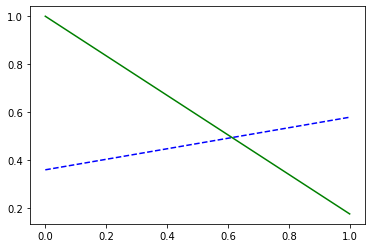

In [46]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

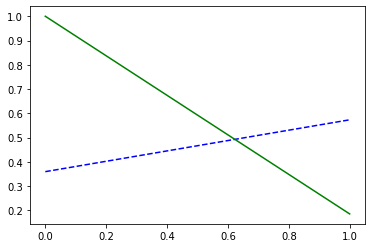

In [47]:
precisions, recalls, thresholds = precision_recall_curve(data_labels, tree_predictions)
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

## Grid-Search

- Ensemble methods - Voting, Boosting, Random Forest

In [60]:
from sklearn.model_selection import GridSearchCV
param_grid = [
 {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
 {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}]
grid_search = GridSearchCV(rnd_clf, param_grid, cv=5, scoring='f1_micro', return_train_score=True)
grid_search.fit(data_processed, data_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid